In [1]:
import torch
import matplotlib.pyplot as plt
import torch
from importlib import reload 
from pathlib import Path 

from unlearning.datasets import gaussian 

from unlearning import probes, leace, plotting
reload(probes)
reload(plotting)
reload(leace)
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'



def check_memory():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1024 ** 2} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB")
    print(f"Max Memory Cached: {torch.cuda.max_memory_reserved() / 1024 ** 2} MB")  


BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)



Using device: cuda


okay, now that a linear probe is set up, let's test the accuracy on different layers in a real model
# setting up a real model 

Files already downloaded and verified
Files already downloaded and verified


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


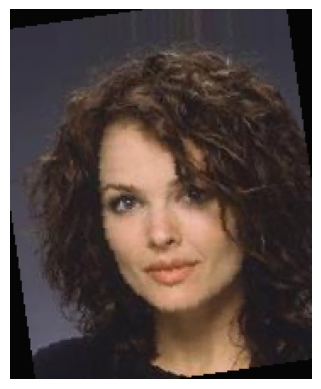

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets
from unlearning import model_utils
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

from torch.utils.data import DataLoader, Subset
import json
import yaml  
def save_yaml(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file)

import pickle 
def save_pickle(params, filename):
    with open(filename, 'wb') as file:
        pickle.dump(params, file)
from pathlib import Path    



DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")

# ========================
# 2. DATA LOADING
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

NUM_WORKERS = 4
train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


BATCH_SIZE= 1024
    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



from unlearning import plotting
reload(plotting)

image_ = val_dataset[0][0]
plotting.show_image(image_)


## Load model

In [3]:
print(f"load model:")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)


model = model_utils.load_model(attr_index=1, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


print(f"evaluate model:")
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = 4)



vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]



model_layer_count = probes.get_layer_count(model)
print(f"layer count - {model_layer_count}")

# print model accuracy
accuracy = (all_preds == all_labels).float().mean()

#

load model:
Using device: cuda


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

evaluate model:


 25%|██▌       | 5/20 [00:33<01:41,  6.79s/it]

layer count - 10


In [4]:

check_memory()
print(f"model accuracy - {accuracy}")
attribute_index = 20


print(f"vals[{attribute_index} ] = {vals[attribute_index]}")
reload(plotting)
print(f"accuracy - {plotting.compute_precision_recall_acc(vals[attribute_index])}")
# get probe accuracy 
#train_labels = train_dataset.attr
val_labels = val_dataset.attr
# attribute names 
attr_names = val_dataset.attr_names
print(f"attribute of interest - {attr_names[attribute_index]}")

positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0


N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)


# set up a probe dataset 
print(f"len pos_indices - {len(pos_indices)}")
print(f"len neg_indices - {len(neg_indices)}")
# shuffle neg_indices



Memory Allocated: 122.224609375 MB
Max Memory Allocated: 8624.427734375 MB
Memory Cached: 10912.0 MB
Max Memory Cached: 10912.0 MB
model accuracy - 0.9133007526397705
vals[20 ] = (tensor(2166), tensor(2875), tensor(27), tensor(52))
accuracy - (tensor(98.7688), tensor(97.6555), tensor(98.4570))
attribute of interest - Male
len pos_indices - 8458
len neg_indices - 11409


/tmp/ipykernel_1265239/435768503.py:26: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_1265239/435768503.py:27: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


In [5]:
#print probe layer accs
reload(probes)
plot_probes = False
if plot_probes:
    probes.plot_probes(pos_indices, neg_indices, model, val_dataset, device)


# Identify contrastive examples (for probe-ability) 

Observation, evaluation here should be lower than the general probe-ability.


In [6]:
check_memory()

Memory Allocated: 122.224609375 MB
Max Memory Allocated: 8624.427734375 MB
Memory Cached: 10912.0 MB
Max Memory Cached: 10912.0 MB


In [7]:
layer_ind = 8
positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0
reload(probes)

N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)



probe_dataset, probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices[:N], neg_indices=neg_indices[:N], dataset = val_dataset, device = device, verbose = True)

print(f"probe_dataset - {probe_dataset.shape}")
print(f"probe_labels - {probe_labels.shape}")

generating loader from scratch
batching embeddings


/tmp/ipykernel_1265239/1134818954.py:12: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_1265239/1134818954.py:13: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
probe_dataset - torch.Size([2000, 2048])
probe_labels - torch.Size([2000])


### test embedding search space

In [8]:
# search for the first image 
from unlearning import contrastive_examples
from collections import defaultdict
reload(contrastive_examples)
# build contrastive example_dataset

search_engine = contrastive_examples.build_positive_examples_db(probe_dataset, probe_labels, model, layer_ind)

do_search_demo = False 
if do_search_demo:
    contrastive_examples.search_demo(search_engine, probe_dataset, probe_labels, N = 1000)

model_layer_count- 10
init
model_device: cuda:0
model embeddinging size 2048
embedding 0/2000
embedding 200/2000
embedding 400/2000
embedding 600/2000
embedding 800/2000


### compute distances between negative-examples and positive-examples

In [9]:
reload(probes)
all_neg_indices = torch.where(negative_attributes)[0]
positive_centroid = torch.mean(probe_dataset[probe_labels == 1], dim=0)


nearest_distances = defaultdict(lambda: 1000000)
distance_to_centroid = {}

all_neg_indices = torch.where(negative_attributes)[0]
# shuffle 
all_neg_indices = np.array(all_neg_indices)
np.random.shuffle(all_neg_indices)

indices_to_check =all_neg_indices[:2500]

for neg_ii, neg_image_index in enumerate(indices_to_check):
    if neg_ii % (len(indices_to_check)//10) == 0:
        print(f"embedding {neg_ii}/{len(indices_to_check)}")
    
    image = val_dataset[neg_image_index][0]
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    embedding = probes.get_flattened_embedding(model, layer_ind = layer_ind, x = image)
    results = search_engine.search_embedding(query_embedding = embedding, top_k=3)
    min_index = np.argmin([dist for (pos_ind, dist) in results])    
    pos_ind, min_dist = results[min_index]
    nearest_distances[neg_image_index] = min_dist

    # report distance to centroid
    distance_to_centroid[neg_image_index] = torch.norm(positive_centroid - embedding.cpu()).item()

embedding 0/2500


/tmp/ipykernel_1265239/1346302998.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_neg_indices = np.array(all_neg_indices)


embedding 250/2500
embedding 500/2500
embedding 750/2500
embedding 1000/2500
embedding 1250/2500
embedding 1500/2500
embedding 1750/2500
embedding 2000/2500
embedding 2250/2500


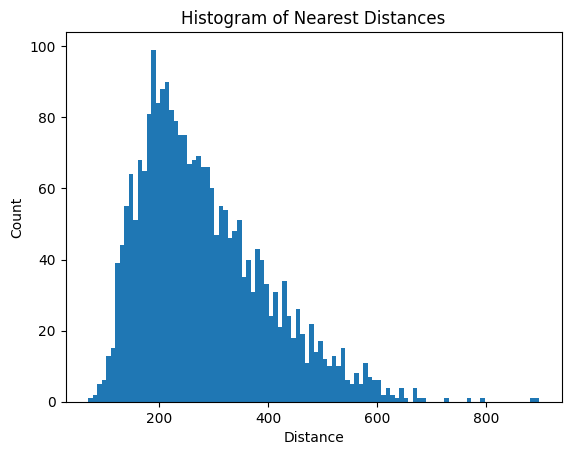

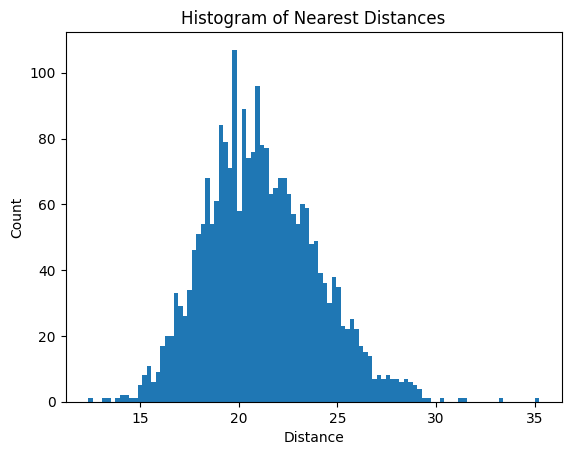

2500
pearson_corr between ranking of nearest distances to centroid distance - 0.9878485177355085


In [10]:
# plot nearest_distances
# plot hist of nearest_distances

plt.hist(list(nearest_distances.values()), bins=100)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Nearest Distances")
plt.show()


# plot distance_to_centroid
plt.hist(list(distance_to_centroid.values()), bins=100)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Nearest Distances")
plt.show()


# order nearest_distances
ordered_nearest_distances = sorted(nearest_distances.items(), key=lambda x: x[1])
# order distance_to_centroid
ordered_distance_to_centroid = sorted(distance_to_centroid.items(), key=lambda x: x[1])
length = min(len(ordered_nearest_distances), len(ordered_distance_to_centroid))

print(length)
# print the pearson rank correlation between the two
import scipy.stats as stats
pearson_corr, _ = stats.pearsonr([x[1] for x in ordered_nearest_distances[:length]], [x[1] for x in ordered_distance_to_centroid[:length]])
print(f"pearson_corr between ranking of nearest distances to centroid distance - {pearson_corr}")


### observe that picking 1-NN embedding distance to any point, or just to the center has a very similar ranking: 

As the pearson_corr between ranking of nearest distances to centroid distance - 0.9843334185769756


## construct probing-dataset from the constrastive examples

In [11]:
# pick top 1000 of 
print(f"layer_ind- {layer_ind}")
N = len(pos_indices)
#N = 500# 1000
print(f"N - {N}")
N = min(N, len(ordered_nearest_distances), 1000 )

closest_neg_indices = [int(ordered_nearest_distances[i][0]) for i in range(N)]
closest_neg_indices = np.array(closest_neg_indices)


## base probe
#shuffle neg_indices, choose 1000 random points from neg_indices
neg_indices_normal = np.random.choice(all_neg_indices, size=N, replace=False)


normal_probe_dataset, normal_probe_dataset_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices, neg_indices=neg_indices_normal, dataset =val_dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), verbose = True)



# create probe dataset of these closest_neg_attributes, and positive images

closest_probe_dataset, closest_probe_dataset_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices, neg_indices=closest_neg_indices, dataset =val_dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), verbose = True)
    
#val_dataset[0][0].shape



layer_ind- 8
N - 8458
generating loader from scratch
batching embeddings


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing batch 1/34
Processing batch 5/34
Processing batch 9/34
Processing batch 13/34
Processing batch 17/34
Processing batch 21/34
Processing batch 25/34
Processing batch 29/34
Processing batch 33/34
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/34
Processing batch 5/34
Processing batch 9/34
Processing batch 13/34
Processing batch 17/34
Processing batch 21/34
Processing batch 25/34
Processing batch 29/34
Processing batch 33/34
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4


In [12]:
reload(contrastive_examples)


def create_probe_dataset_contrastive_examples(dataset, labels, model, layer_ind, attribute_index, N = 1000, N_to_search= 2000):
    """
    Construct a dataset for the probe by randomly selecting all the positive points, and the closest negative examples to the positive examples, in the dataset validation dataset.

    N_to_search - number of negative examples to search
    """

    positive_attributes = labels[:, attribute_index] == 1
    negative_attributes = labels[:, attribute_index] == 0
    #
    pos_indices = torch.where(positive_attributes)[0]
    neg_indices = torch.where(negative_attributes)[0]
    #    
    # shuffle pos_indices
    np.random.shuffle(pos_indices)
    np.random.shuffle(neg_indices)

    probe_labels = labels[:, attribute_index] == 1
    print(f"probe_labels {len(probe_labels)} ; {type(probe_labels)}")
    # search the negative examples, for closest examples to the positive examples 
    search_engine = contrastive_examples.build_positive_examples_db_from_model(dataset=dataset,model= model, positive_indices=pos_indices[:N_to_search], layer_ind = layer_ind)

    print(f"built search engine")
    closest_neg_indices = contrastive_examples.find_closest_examples(search_engine=search_engine, dataset=dataset, neg_indices = neg_indices[:N_to_search], layer_ind=layer_ind, model= model, top_N = N)
    print(f"len(closest_neg_indices) - {len(closest_neg_indices)}")
    
    # create probe dataset of these closest_neg_attributes, and positive images
    print(f"closest_neg_indices -{len(closest_neg_indices)}")

    closest_probe_dataset, closest_probe_dataset_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices[:N], neg_indices=closest_neg_indices, dataset = dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), verbose = True)
    return closest_probe_dataset, closest_probe_dataset_labels

N = 200
### Pulling out the - create probe-dataset function.
closest_probe_dataset, closest_probe_dataset_labels = create_probe_dataset_contrastive_examples(dataset= val_dataset, labels= val_labels, model = model, layer_ind = layer_ind, attribute_index=attribute_index, N =N, N_to_search=N*4)


/tmp/ipykernel_1265239/3461451100.py:18: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_1265239/3461451100.py:19: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


probe_labels 19867 ; <class 'torch.Tensor'>
model_layer_count- 10
init
model_device: cuda:0
model embeddinging size 2048
embedding 0/800; embedding_counts 1
embedding 80/800; embedding_counts 81
embedding 160/800; embedding_counts 161
embedding 240/800; embedding_counts 241
embedding 320/800; embedding_counts 321
embedding 400/800; embedding_counts 401
embedding 480/800; embedding_counts 481
embedding 560/800; embedding_counts 561
embedding 640/800; embedding_counts 641
embedding 720/800; embedding_counts 721
built search engine
embedding 0/1000
embedding 100/1000
embedding 200/1000
embedding 300/1000
embedding 400/1000
embedding 500/1000
embedding 600/1000
embedding 700/1000
ordered_nearest_distances- len210
len(closest_neg_indices) - 200
closest_neg_indices -200
generating loader from scratch
batching embeddings
Processing batch 1/1
generating loader from scratch
batching embeddings
Processing batch 1/1


(array([200.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 200.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.90000004,
        1.        ]),
 <BarContainer object of 10 artists>)

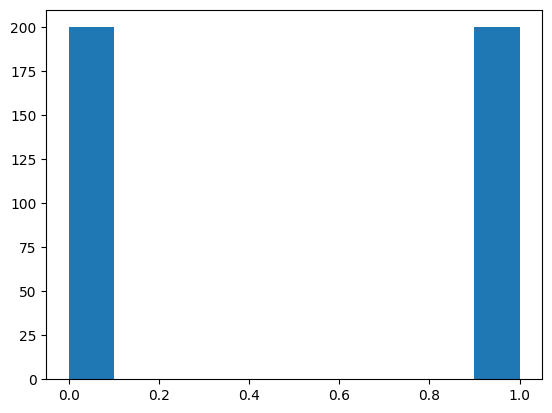

In [18]:
plt.hist(closest_probe_dataset_labels)

In [14]:
# test probe
reload(probes)


print(f"Probe on random vals")

linear_probe_random = probes.test_linear_probe(normal_probe_dataset, normal_probe_dataset_labels, model, num_epochs= 1000, verbose= False)
MLP_probe_random = probes.test_MLP_probe(normal_probe_dataset, normal_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

print(f"\tlinear_probe_random_acc - {linear_probe_random[0]}")
print(f"\tMLP_probe_random_acc - {MLP_probe_random[0]}")


print(f"Probe on closest vals")
linear_probe_closest = probes.test_linear_probe(closest_probe_dataset, closest_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

MLP_probe_closest = probes.test_MLP_probe(closest_probe_dataset, closest_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

print(f"\tlinear_probe_closest_acc - {linear_probe_closest[0]}")
print(f"\tMLP_probe_closest_acc - {MLP_probe_closest[0]}")


Probe on random vals
	linear_probe_random_acc - 99.19644594192505
	MLP_probe_random_acc - 99.8731255531311
Probe on closest vals
	linear_probe_closest_acc - 99.50000047683716
	MLP_probe_closest_acc - 100.0


In [15]:
# now test probe accuracy with better contrastive examples chosen

embedding_1, image_index_1 = probe_dataset[0], 0
search_engine.add_embedding(embedding = embedding_1, image_index = image_index_1)

if False:
    search_engine = ImageSearch()
    search_engine.load_images_from_directory('path_to_your_image_folder')

    results = search_engine.search_image('path_to_query_image.jpg', top_k=3)
    for path, dist in results:
        print(f"Matched Image: {path}, Distance: {dist}")
